# Lab 10: Fully Connected Neural Networks

In this assignment, we will learn fully connected neural network.


## 1. Example

This assignement should be run on Google Colab where you can use free GPU to accelerate the computation. Please refer to our slides to set up GPU.

### 1. Install Pytorch

In [1]:
!pip3 install torch torchvision   # install pytorch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

### 2. Check GPU

In [2]:
!/opt/bin/nvidia-smi  #show GPU

Thu Apr 25 19:52:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 3. Mount to google drive (optional)

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 4. Code

In [38]:
#Import Libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [47]:
args={}
args['batch_size']=100
args['test_batch_size']=100
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset.
args['lr']=0.01 #Learning rate is how fast it will decend.
args['log_interval']=10

In [22]:
# build an mlp
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)  # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,10)  # linear layer (128 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.relu(self.fc1(h0)) # hidden layer 1
        h2 = F.relu(self.fc2(h1)) # hidden layer 2
        h3 = self.fc3(h2) # output layer

        return h3

model = Net()
model.cuda() # put the model on GPU
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [49]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = args['lr'])

In [50]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False)

In [51]:
def train(epoch):
    train_history = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target)

        # compute gradients
        optimizer.zero_grad()
        loss.backward()

        #to do a one-step update on our parameter.
        optimizer.step()

        train_history.append(loss.item())

        #Print out the loss periodically.
        if batch_idx % args['log_interval'] == 0:
          if batch_idx % 15 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return train_history

In [52]:
def test():
    model.eval()
    test_loss = 0
    correct = 0

    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()

        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss


In [10]:
for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299297
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.197578
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.124905
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.931895
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.679415
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.412461
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.174098
Train Epoch: 1 [21000/60000 (35%)]	Loss: 1.006796
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.795747
Train Epoch: 1 [27000/60000 (45%)]	Loss: 0.696676
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.686059
Train Epoch: 1 [33000/60000 (55%)]	Loss: 0.696888
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.656574
Train Epoch: 1 [39000/60000 (65%)]	Loss: 0.594765
Train Epoch: 1 [42000/60000 (70%)]	Loss: 0.512147
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.500368
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.606273
Train Epoch: 1 [51000/60000 (85%)]	Loss: 0.515579
Train Epoch: 1 [54000/60000 (90%)]	Loss: 0.443858
Train Epoch: 1 [57000/60000 (95%)]	Loss: 0.532286

Test set

## 2. Tasks

### 1. Please use other activation functions, e.g., sigmoid, tanh, and then plot the training loss and testing accuracy.

When plotting the training loss, the x-axis is iteration and the y-axis is training loss. When plotting the testing accuracy,  the x-axis is epoch and the y-axis is the training loss.

In [48]:
# change activation functions
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)  # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,10)  # linear layer (128 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.sigmoid(self.fc1(h0)) # hidden layer 1 : sigmoid activation
        h2 = F.tanh(self.fc2(h1)) # hidden layer 2 : tanh activation
        h3 = self.fc3(h2) # output layer

        return h3

model = Net()
model.cuda() # put the model on GPU
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [53]:
import matplotlib.pyplot as plt

def plot_train_loss(history):
  plt.subplot(1, 2, 1)
  plt.plot(history, label='loss')
  plt.xlabel('Iteration')
  plt.ylabel('Training Loss')
  plt.legend()
  plt.grid(True)
  plt.title('Training Loss vs Iteration')

def plot_test_loss(history):
  plt.subplot(1, 2, 2)
  plt.plot(history, label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Testing Loss')
  plt.legend()
  plt.grid(True)
  plt.title('Testing Loss vs Epoch')


In [54]:


train_losses = []
test_losses = []

for epoch in range(1, args['epochs'] + 1):
    #training
    train_loss = train(epoch)
    train_losses.extend(train_loss)
    test_loss = test()

    #testing
    test_loss = test()
    test_losses.append(test_loss)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.340813
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.270508
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.253603
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.214084
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.164426
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.158193
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.107555
Train Epoch: 1 [21000/60000 (35%)]	Loss: 2.067369
Train Epoch: 1 [24000/60000 (40%)]	Loss: 2.056629
Train Epoch: 1 [27000/60000 (45%)]	Loss: 1.948160
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.939996
Train Epoch: 1 [33000/60000 (55%)]	Loss: 1.847855
Train Epoch: 1 [36000/60000 (60%)]	Loss: 1.810020
Train Epoch: 1 [39000/60000 (65%)]	Loss: 1.740476
Train Epoch: 1 [42000/60000 (70%)]	Loss: 1.624581
Train Epoch: 1 [45000/60000 (75%)]	Loss: 1.629943
Train Epoch: 1 [48000/60000 (80%)]	Loss: 1.477861
Train Epoch: 1 [51000/60000 (85%)]	Loss: 1.364958
Train Epoch: 1 [54000/60000 (90%)]	Loss: 1.339141
Train Epoch: 1 [57000/60000 (95%)]	Loss: 1.277087

Test set

<Figure size 1000x500 with 0 Axes>

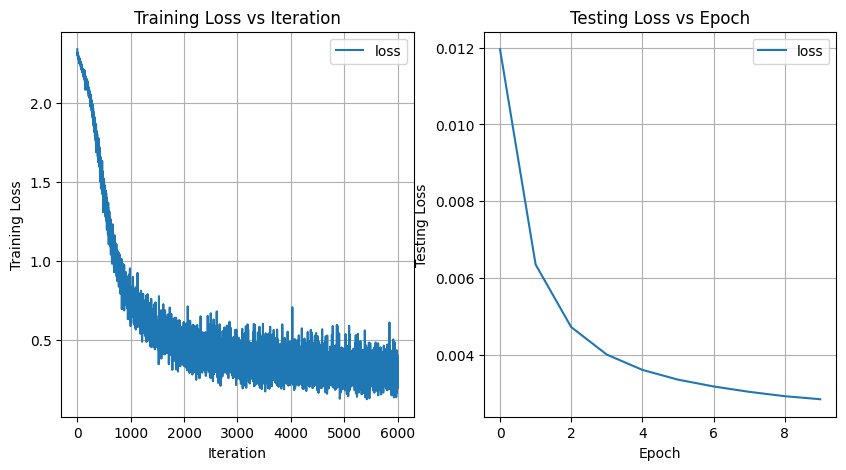

In [56]:
plt.figure(figsize=(10, 5))
plot_train_loss(train_losses)
plot_test_loss(test_losses)
plt.show()

### 2. Please use different layers in the model, e.g., 1 layer, 5 layers, 10 layers,  and then plot the training loss and testing accuracy.



###1 Layer

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,10)  # linear layer (256 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.sigmoid(self.fc1(h0)) # hidden layer 1 : sigmoid activation
        h2 = self.fc2(h1) # output layer

        return h2

model = Net()
model.cuda() # put the model on GPU
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292063
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.245961
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.215818
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.235398
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.185279
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.180984
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.127161
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.093777
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.079797
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.073580
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.037618
Train Epoch: 1 [11000/60000 (18%)]	Loss: 2.024219
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.014597
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.965510
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.937745
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.937533
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.879572
Train Epoch: 1 [17000/60000 (28%)]	Loss: 1.851691
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.769065
Train Epoch: 1 [19000/60000 (32%)]	Loss: 1.733240
Train Epoch: 1 [200

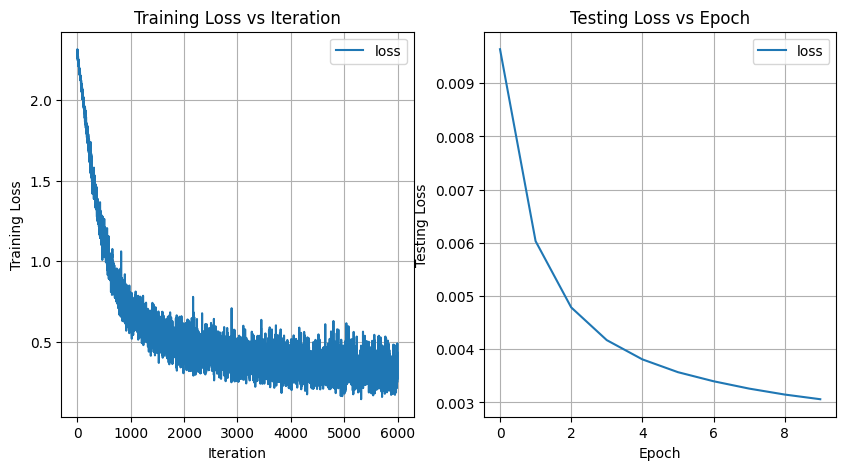

In [ ]:


train_losses = []
test_losses = []

for epoch in range(1, args['epochs'] + 1):
    #training
    train_loss = train(epoch)
    train_losses.extend(train_loss)

    #testing
    test_loss = test()
    test_losses.append(test_loss)

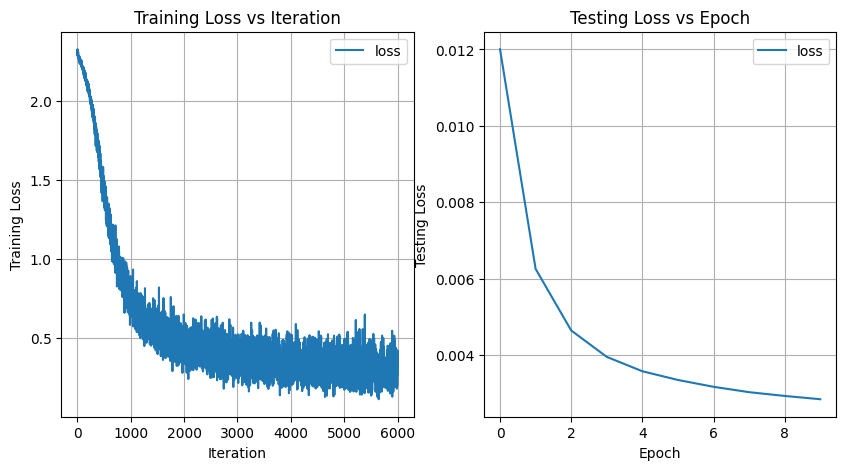

In [20]:
#plot losses
plt.figure(figsize=(10, 5))
plot_train_loss(train_losses)
plot_test_loss(test_losses)
plt.show()


###5 Layers



In [31]:
# 5 layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(28*28, 256)  # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)     # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,64)      # linear layer (128 -> 64)
        self.fc4 = nn.Linear(64,32)       # linear layer (64 -> 32)
        self.fc5 = nn.Linear(32, 16)      # linear layer (32 -> 16)
        self.fc6 = nn.Linear(16, 10)      # linear layer (16 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28)         # input layer
        h1 = F.sigmoid(self.fc1(h0))  # hidden layer 1 : sigmoid activation
        h2 = F.tanh(self.fc2(h1))     # hidden layer 2 : tanh activation
        h3 = F.relu(self.fc3(h2))     # hidden layer 3: relu activation
        h4 = F.softmax(self.fc4(h3))  # hidden layer 4: softmax activation
        h5 = F.tanh(self.fc5(h4))     # hidden layer 5: tanh activation
        h6 = self.fc6(h5)             # output layer

        return h6

model = Net()
model.cuda() # put the model on GPU
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=16, bias=True)
  (fc6): Linear(in_features=16, out_features=10, bias=True)
)


In [36]:


train_losses = []
test_losses = []

for epoch in range(1, args['epochs'] + 1):
    #training
    train_loss = train(epoch)
    train_losses.extend(train_loss)

    #testing
    test_loss = test()
    test_losses.append(test_loss)

<ipython-input-31-4cfd395892ef>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  h4 = F.softmax(self.fc4(h3))  # hidden layer 4: softmax activation


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.290409
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.312264
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.322910
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.324292
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.313117
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.321692
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.288931
Train Epoch: 1 [21000/60000 (35%)]	Loss: 2.307591
Train Epoch: 1 [24000/60000 (40%)]	Loss: 2.307508
Train Epoch: 1 [27000/60000 (45%)]	Loss: 2.311043
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.304227
Train Epoch: 1 [33000/60000 (55%)]	Loss: 2.294347
Train Epoch: 1 [36000/60000 (60%)]	Loss: 2.316291
Train Epoch: 1 [39000/60000 (65%)]	Loss: 2.292030
Train Epoch: 1 [42000/60000 (70%)]	Loss: 2.308938
Train Epoch: 1 [45000/60000 (75%)]	Loss: 2.293274
Train Epoch: 1 [48000/60000 (80%)]	Loss: 2.322698
Train Epoch: 1 [51000/60000 (85%)]	Loss: 2.313983
Train Epoch: 1 [54000/60000 (90%)]	Loss: 2.313167
Train Epoch: 1 [57000/60000 (95%)]	Loss: 2.301479

Test set

<Figure size 1000x500 with 0 Axes>

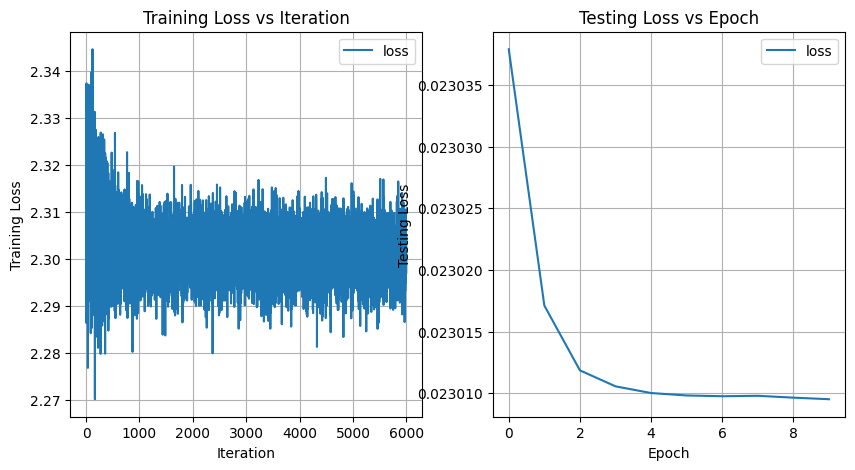

In [37]:
#plot losses
plt.figure(figsize=(10, 5))
plot_train_loss(train_losses)
plot_test_loss(test_losses)
plt.show()


###10 Layers

In [40]:
# 10 layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(28*28, 512)  # linear layer (784 -> 512)
        self.fc2 = nn.Linear(512,256)     # linear layer (512 -> 256)
        self.fc3 = nn.Linear(256,128)     # linear layer (256 -> 128)
        self.fc4 = nn.Linear(128,64)      # linear layer (128 -> 64)
        self.fc5 = nn.Linear(64, 32)      # linear layer (64 -> 32)
        self.fc6 = nn.Linear(32, 16)      # linear layer (32 -> 16)
        self.fc7 = nn.Linear(16, 12)      # linear layer (16 -> 12)
        self.fc8 = nn.Linear(12, 10)      # linear layer (12 -> 10)
        self.fc9 = nn.Linear(10, 10)      # linear layer (10 -> 10)
        self.fc10 = nn.Linear(10,10)      # linear layer (10 -> 10)
        self.fc11 = nn.Linear(10,10)      # linear layer (10 -> 10)


    def forward(self, x):
        h0 = x.view(-1,28*28)         #input layer
        h1 = F.sigmoid(self.fc1(h0))  # hidden layer 1 : sigmoid activation
        h2 = F.tanh(self.fc2(h1))     # hidden layer 2 : tanh activation
        h3 = F.relu(self.fc3(h2))     # hidden layer 3: relu activation
        h4 = F.softmax(self.fc4(h3))  # hidden layer 4: softmax activation
        h5 = F.tanh(self.fc5(h4))     # hidden layer 5: tanh activation
        h6 = F.tanh(self.fc6(h5))     # hidden layer 6: tanh activation
        h7 = F.relu(self.fc7(h6))     # hidden layer 7: relu activation
        h8 = F.tanh(self.fc8(h7))     # hidden layer 8: tanh activation
        h9 = F.sigmoid(self.fc9(h8))  # hidden layer 9: sigmoid activation
        h10 = F.tanh(self.fc10(h9))   # hidden layer 10: tanh activation
        h11 = self.fc11(h10)          # output layer

        return h11


model = Net()
model.cuda() # put the model on GPU
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=16, bias=True)
  (fc7): Linear(in_features=16, out_features=12, bias=True)
  (fc8): Linear(in_features=12, out_features=10, bias=True)
  (fc9): Linear(in_features=10, out_features=10, bias=True)
  (fc10): Linear(in_features=10, out_features=10, bias=True)
  (fc11): Linear(in_features=10, out_features=10, bias=True)
)


In [45]:
#plot losses
plt.figure(figsize=(10, 5))

train_losses = []
test_losses = []

for epoch in range(1, args['epochs'] + 1):
    #training
    train_loss = train(epoch)
    train_losses.extend(train_loss)

    #testing
    test_loss = test()
    test_losses.append(test_loss)

<ipython-input-40-7a8ee4a67027>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  h4 = F.softmax(self.fc4(h3))  # hidden layer 4: softmax activation


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.349704
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.322647
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.302515
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.308519
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.340788
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.336845
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.324302
Train Epoch: 1 [21000/60000 (35%)]	Loss: 2.322477
Train Epoch: 1 [24000/60000 (40%)]	Loss: 2.296445
Train Epoch: 1 [27000/60000 (45%)]	Loss: 2.321664
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.321329
Train Epoch: 1 [33000/60000 (55%)]	Loss: 2.296561
Train Epoch: 1 [36000/60000 (60%)]	Loss: 2.308517
Train Epoch: 1 [39000/60000 (65%)]	Loss: 2.292951
Train Epoch: 1 [42000/60000 (70%)]	Loss: 2.304244
Train Epoch: 1 [45000/60000 (75%)]	Loss: 2.304089
Train Epoch: 1 [48000/60000 (80%)]	Loss: 2.304603
Train Epoch: 1 [51000/60000 (85%)]	Loss: 2.307087
Train Epoch: 1 [54000/60000 (90%)]	Loss: 2.294581
Train Epoch: 1 [57000/60000 (95%)]	Loss: 2.300311

Test set

<Figure size 1000x500 with 0 Axes>

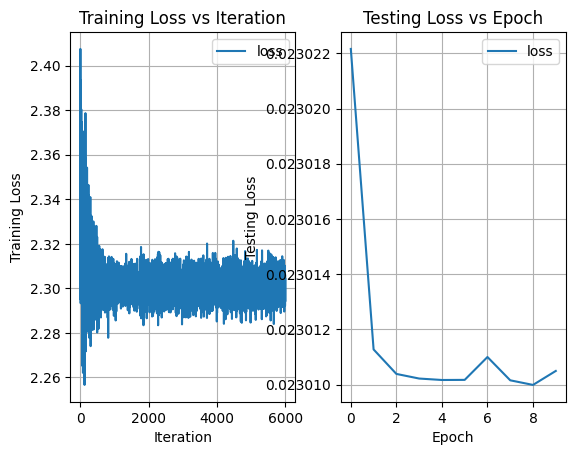

In [46]:
plt.figure(figsize=(10, 5))
plot_train_loss(train_losses)
plot_test_loss(test_losses)
plt.show()

###Conclusion:
The simpler models with less layers performed better than the deeper models with more layers. The deeper models seemed to be prone to overfitting.